# Intrusion Detection Computer Vision System

## Task 1 (Mandatory):
### Graphical Output
For each frame of the input video the system needs to show found blobs (either by coloring them on a black background or by showing the countours over the original video)
### Text Output
For each frame print the number of found objects, the value associated with each feature of the blob and its classification into person or other.

## Task 2 (Optional)
Develop an algorithm to distinguish between true objects and the removal of a previously present one.

## Video Characteristics
- 12 fps
- ~41s
- 320x240 pixels
- 8 bit/pixel (256 gray levels)

In [4]:
# Imports

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [5]:
# Global variables

input_video_path = "rilevamento-intrusioni-video.avi"
output_video_path = "test.avi"

In [15]:
# Video helper functions

def play_video(video_path):
    '''
        Plays the video found in video_path frame by frame
    '''
    cap = cv2.VideoCapture(video_path)
    
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret or frame is None:
                cap.release()
                print("Released Video Resource")
                break
            
            # Display frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.imshow(frame)
            plt.show()
            
            # Clear cell output when new frame is available
            display.clear_output(wait=True)
    except KeyboardInterrupt:
        cap.release()
        print("Released Video Resource")    

def edit_video(input_video_path, output_video_path, frame_transformation):
    '''
        Applies frame_transformation function to each frame taken from input_video_path and saves the result in
        output_video_path
    '''
    cap = cv2.VideoCapture(input_video_path)

    # Getting original video params
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (w,  h))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        frame = frame_transformation(frame)
        # write the updated frame
        out.write(frame)
    cap.release()
    out.release()
    

In [12]:
# Frame editing functions

def flip_frame(frame):
    '''
        Flips the image both vertically and horizontally
    '''
    return np.flip(frame, axis=0)

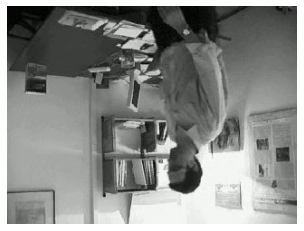

In [ ]:
edit_video(input_video_path, output_video_path, flip_frame)
play_video(output_video_path)